# 2. Classification

Qinghai University for Nationalities, *Python Data Analysis in Finance* course, machine learning part.

Author: *cloudy-sfu*

## Data pre-processing

Read the Iris dataset.

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
x = iris.data
y = iris.target

Split the dataset into the training and testing set.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1536)

We also prepare standardized dataset for support vector machine model.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit(x_test)

## Decision tree

Information entropy:

In a subset (X, Y), we can partition the samples based on the unique values of Y:

```
(X[Y=y_1], Y[Y=y_1]), ..., (X[Y=y_k], Y[Y=y_k])
```

Therefore, we have $k$ subsets because Y has $k$ unique values. The information entropy $H$ of such partition is

$$
p_i = {1[Y=y_i] \over n} \quad i = 1, ..., k \\
H = - \sum_{i=1}^k p_i \log_2 p_i
$$

The information entropy of the whole training set is **root entropy**.

In [ ]:
import numpy as np

def entropy(a: np.ndarray) -> float:
    _, c = np.unique(a, return_counts=True)
    p = c / a.shape[0]
    H = - np.sum(p * np.log2(p))
    return H

root_entropy = entropy(y_train)
root_entropy

1.5840530131956925

Draw the information entropy of a partition, where the number of unique values of $Y$ is 2.

<ipython-input-5-b137f86ded6d>:5: RuntimeWarning: divide by zero encountered in log2
  H = - p * np.log2(p) - (1 - p) * np.log2(1 - p)
<ipython-input-5-b137f86ded6d>:5: RuntimeWarning: invalid value encountered in multiply
  H = - p * np.log2(p) - (1 - p) * np.log2(1 - p)


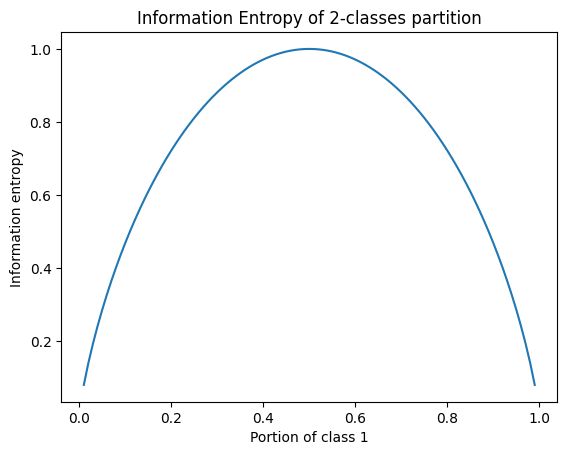

In [ ]:
import matplotlib.pyplot as plt

def draw_2_classes():
    p = np.linspace(0, 1, 101)
    H = - p * np.log2(p) - (1 - p) * np.log2(1 - p)
    
    fig, ax = plt.subplots()
    ax.plot(p, H)
    ax.set_title('Information Entropy of 2-classes partition')
    ax.set_xlabel('Portion of class 1')
    ax.set_ylabel('Information entropy')
    return fig

fig = draw_2_classes()
fig.show()

Draw the information entropy of a partition, where the number of unique values of $Y$ is 3.

<ipython-input-6-80cf7aac1665>:6: RuntimeWarning: divide by zero encountered in log2
  zz = - xx * np.log2(xx) - yy * np.log2(yy) - (1 - xx - yy) * np.log2(1 - xx - yy)
<ipython-input-6-80cf7aac1665>:6: RuntimeWarning: invalid value encountered in log2
  zz = - xx * np.log2(xx) - yy * np.log2(yy) - (1 - xx - yy) * np.log2(1 - xx - yy)
<ipython-input-6-80cf7aac1665>:6: RuntimeWarning: invalid value encountered in multiply
  zz = - xx * np.log2(xx) - yy * np.log2(yy) - (1 - xx - yy) * np.log2(1 - xx - yy)


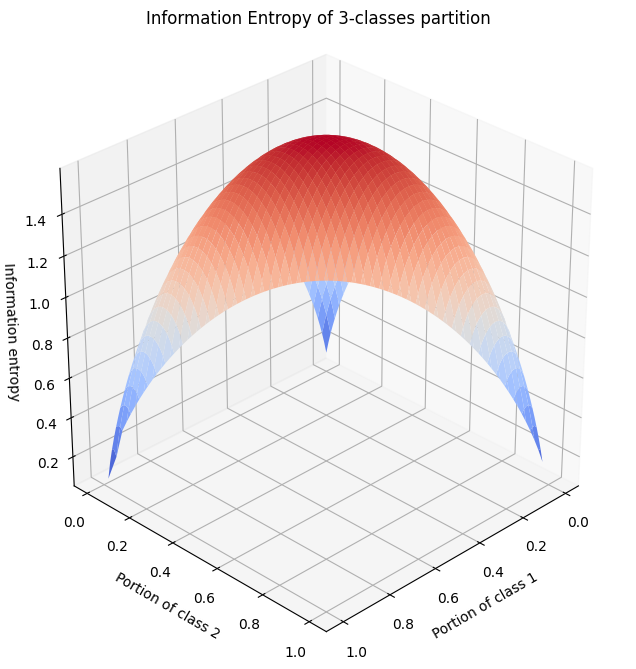

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def draw_3_classes():
    xx, yy = np.meshgrid(np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 100))
    zz = - xx * np.log2(xx) - yy * np.log2(yy) - (1 - xx - yy) * np.log2(1 - xx - yy)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(xx, yy, zz, cmap='coolwarm')
    ax.view_init(elev=30, azim=45)  # Set rotation angle
                                    # add elev: overlook
    ax.set_box_aspect(aspect = (1,1,1))
    ax.set_title('Information Entropy of 3-classes partition')
    ax.set_xlabel('Portion of class 1')
    ax.set_ylabel('Portion of class 2')
    ax.set_zlabel('Information entropy')
    return fig

fig = draw_3_classes()
fig.show()

Decision tree has a tree structure. In each branch, it uses such splitting rule as the partition plan:

```
the value of a particular attribute <= a particular threshold
```

For example, `sepal width <= 3.4` is a splitting rule. If a sample satisfies such condition, it goes to a "Yes" branch, otherwise it goes to a "No" branch.

If an attribute (or column) is dicrete, the threshold is all unique values; if an attribute (or column) is continuous, the threshold is all unique values appeard in the training set as well.


In [ ]:
import pandas as pd

splitting_rules = []
for col in x_train.columns:
    u = np.unique(x_train.loc[:, col])
    median_between_u = (u[:-1] + u[1:]) * 0.5
    for u in median_between_u:
        idx = x_train.loc[:, col] <= u  # "Yes" branch
        root_entropy = entropy(y_train)
        yes_entropy = entropy(y_train[idx])
        no_entropy = entropy(y_train[~idx])
        p = np.mean(idx)
        IG = root_entropy - yes_entropy * p - no_entropy * (1-p)
        splitting_rules.append({'column': col, 'threshold': u, 'IG': IG,
                                'root_entropy': root_entropy, 'partition': p, 
                                'yes_entropy': yes_entropy, 'no_entropy': no_entropy})
splitting_rules = pd.DataFrame(splitting_rules)
splitting_rules

,column,threshold,IG,root_entropy,partition,yes_entropy,no_entropy
0,sepal length (cm),4.35,0.013009,1.584053,0.008333,-0.000000,1.584246
1,sepal length (cm),4.50,0.053260,1.584053,0.033333,-0.000000,1.583579
2,sepal length (cm),4.65,0.081189,1.584053,0.050000,-0.000000,1.581962
3,sepal length (cm),4.75,0.110071,1.584053,0.066667,-0.000000,1.579267
4,sepal length (cm),4.85,0.155349,1.584053,0.091667,-0.000000,1.572885
...,...,...,...,...,...,...,...
106,petal width (cm),2.05,0.274456,1.584053,0.858333,1.525744,-0.000000
107,petal width (cm),2.15,0.201376,1.584053,0.891667,1.550666,-0.000000
108,petal width (cm),2.25,0.150517,1.584053,0.916667,1.563858,-0.000000
109,petal width (cm),2.35,0.057113,1.584053,0.966667,1.579593,-0.000000


All attributes:

In [ ]:
x_train.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

Get the splitting rule which reaches the maximum value of IG.

In [ ]:
b = np.argmax(splitting_rules['IG'])
splitting_rules.iloc[b, :]

column          petal length (cm)
threshold                    2.45
IG                       0.926405
root_entropy             1.584053
partition                0.341667
yes_entropy                  -0.0
no_entropy                0.99896
Name: 59, dtype: object

Our implemention is the first branching node of decision tree. It has the same behavior as `scikit-learn`.

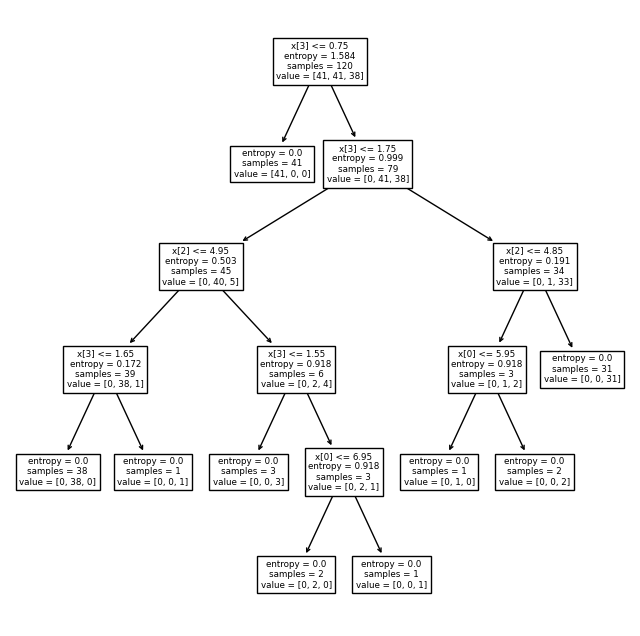

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(criterion='entropy', max_features=None)
dt.fit(x_train, y_train)

fig = plt.figure(figsize=(8, 8))
plot_tree(dt)
fig.show()

For each subsequent node, we consider it as the root node and repeat the splitting process.

## Random forest

In each node, we can use `max_features` and only part of the columns are candidates in each split.

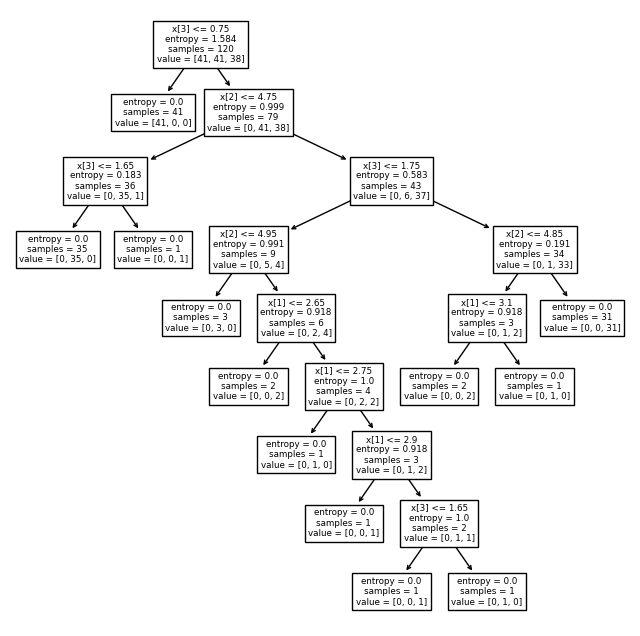

In [ ]:
dt_features_boot = DecisionTreeClassifier(criterion='entropy', max_features=2)
dt_features_boot.fit(x_train, y_train)

fig = plt.figure(figsize=(8, 8))
plot_tree(dt_features_boot)
fig.show()

Random forest model involves a ensemble method "averaging". It parallels several decision tree models, and take the average of their results. For classification problem, they vote for the major nominated class; for regression problem, they output the average from trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3, criterion='entropy', max_features=2)
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=2, n_estimators=3)

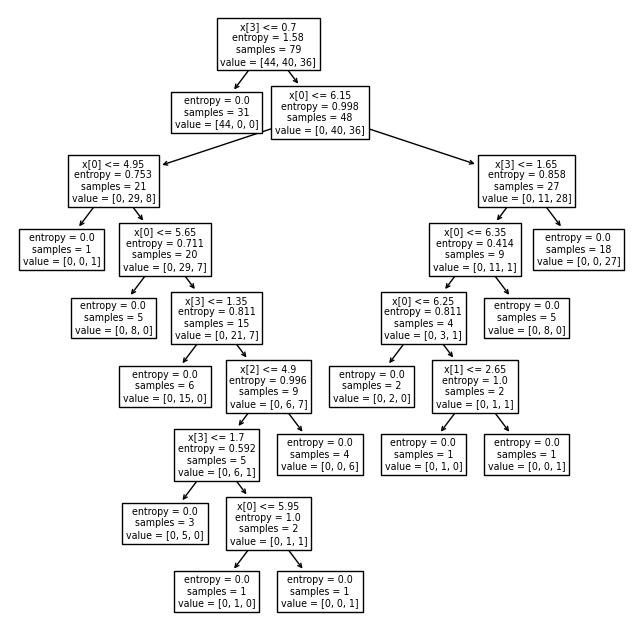

In [ ]:
fig = plt.figure(figsize=(8, 8))
plot_tree(rf.estimators_[0])
fig.show()

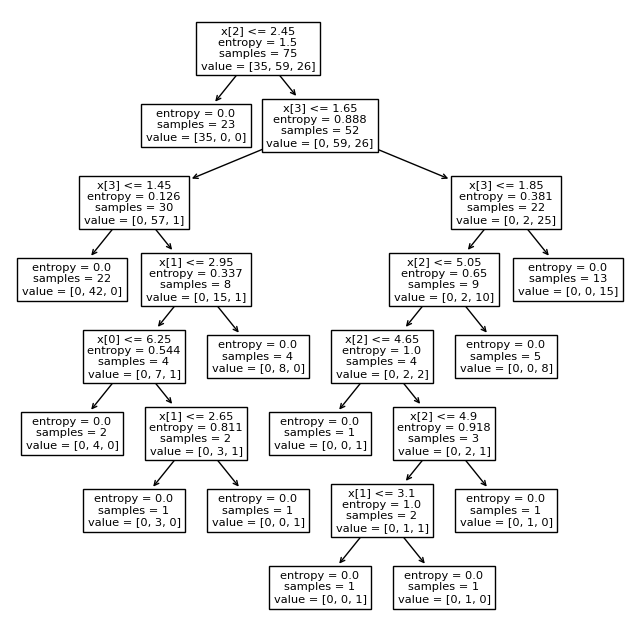

In [ ]:
fig = plt.figure(figsize=(8, 8))
plot_tree(rf.estimators_[1])
fig.show()

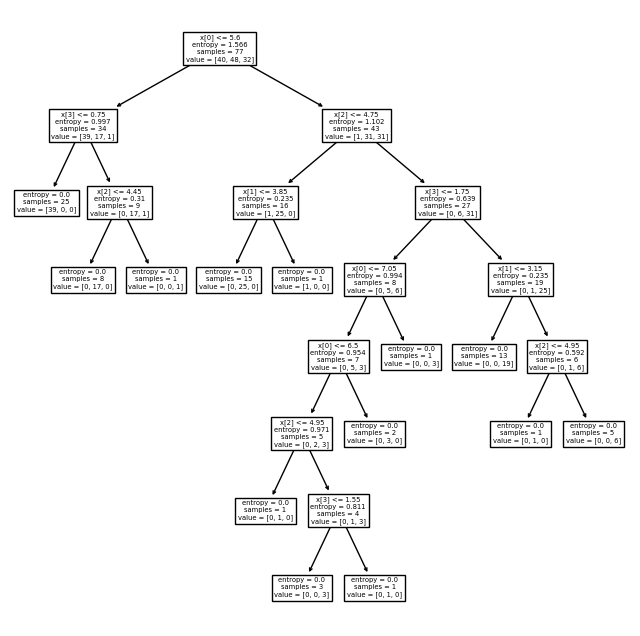

In [ ]:
fig = plt.figure(figsize=(8, 8))
plot_tree(rf.estimators_[2])
fig.show()

In [ ]:
dict(zip(x_train.columns, rf.feature_importances_))

{'sepal length (cm)': 0.16542752572977956,
 'sepal width (cm)': 0.029519895449940298,
 'petal length (cm)': 0.31013514057454966,
 'petal width (cm)': 0.4949174382457305}

## Support vector classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC

In [ ]:
svc = SVC(random_state=1850, C=0.01)
svc.fit(x_train, y_train)

SVC(C=0.01, random_state=1850)

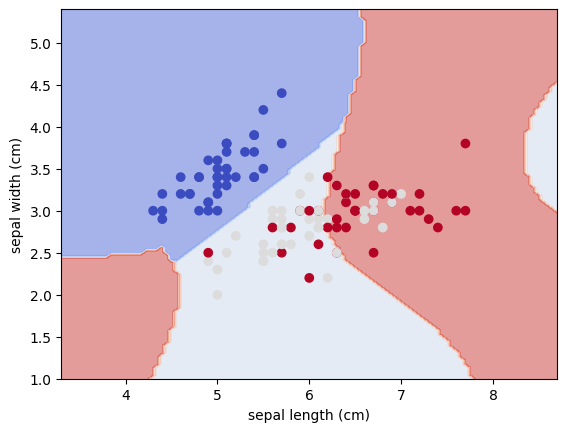

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

svc_2d = SVC(random_state=1850, C=1000, gamma=0.1)
svc_2d.fit(x_train.iloc[:, :2], y_train)
f, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    svc_2d,
    x_train.iloc[:, :2],
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.5,
    ax=ax
)
ax.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, cmap=plt.cm.coolwarm)
plt.show()
plt.close()

## Model evaluation

In [ ]:
from sklearn.metrics import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

The model has such predictions.

|Day | Ground truth | Prediction |
|:--:|:------------:|:----------:|
|1   | Shower       | Shower     |
|2   | Clear        | Shower     |
|3   | Shower       | Clear      |
|4   | Shower       | Shower     |
|5   | Clear        | Shower     |
|6   | Shower       | Shower     |
|7   | Clear        | Shower     |
|8   | Clear        | Clear      |
|9   | Clear        | Clear      |
|10  | Shower       | Shower     |

Draw a confusion matrix.


In [ ]:
y = np.array(["S", "C", "S", "S", "C", "S", "C", "C", "C", "S"])
y_hat = np.array(["S", "S", "C", "S", "S", "S", "S", "C", "C", "S"])

confusion_matrix(y, y_hat, labels=["S", "C"])

array([[4, 1],
       [3, 2]])

Compute accuracy, precision, recall, and F1-score.

In [ ]:
print("Accuracy:", accuracy_score(y, y_hat))
print("Precision (Clear is positive label):", precision_score(y, y_hat, pos_label="C"))
print("Precision (Shower is positive label):", precision_score(y, y_hat, pos_label="S"))
print("Recall (Clear is positive label):", recall_score(y, y_hat, pos_label="C"))
print("Recall (Shower is positive label):", recall_score(y, y_hat, pos_label="S"))
print("F1-score (Clear is postivie label):", f1_score(y, y_hat, pos_label="C"))
print("F1-score (Shower is positive label):", f1_score(y, y_hat, pos_label="S"))

Accuracy: 0.6
Precision (Clear is positive label): 0.6666666666666666
Precision (Shower is positive label): 0.5714285714285714
Recall (Clear is positive label): 0.4
Recall (Shower is positive label): 0.8
F1-score (Clear is postivie label): 0.5
F1-score (Shower is positive label): 0.6666666666666666


We assume "Shower" is the positive label. ROC-AUC metrics is caluclated based on the probability of positive label.

|Day | Ground truth | Prediction |
|:--:|:------------:|:----------:|
|1   | Shower       | 0.95       |
|2   | Clear        | 0.85       |
|3   | Shower       | 0.78       |
|4   | Shower       | 0.66       |
|5   | Clear        | 0.6        |
|6   | Shower       | 0.55       |
|7   | Clear        | 0.53       |
|8   | Clear        | 0.52       |
|9   | Clear        | 0.51       |
|10  | Shower       | 0.4        |

Make a series of thresholds, where the probability larger than this threshold is categorized as positive label.

In [ ]:
y_hat_proba = np.array([.95, .85, .78, .66, .6, .55, .53, .52, .51, .4])

In [ ]:
@np.vectorize
def roc_point(threshold):
  y_hat_ = np.where(y_hat_proba >= threshold, "S", "C")
  cm = confusion_matrix(y, y_hat_, labels=["S", "C"])
  tp, fn, fp, tn = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
  fpr = fp / (fp + tn)
  tpr = tp / (tp + fn)
  return fpr, tpr

fpr_S, tpr_S = roc_point(np.linspace(0.3, 1, 8))
auc_S = auc(fpr_S, tpr_S)

Draw a ROC curve and evaluate the performance with its AUC score.

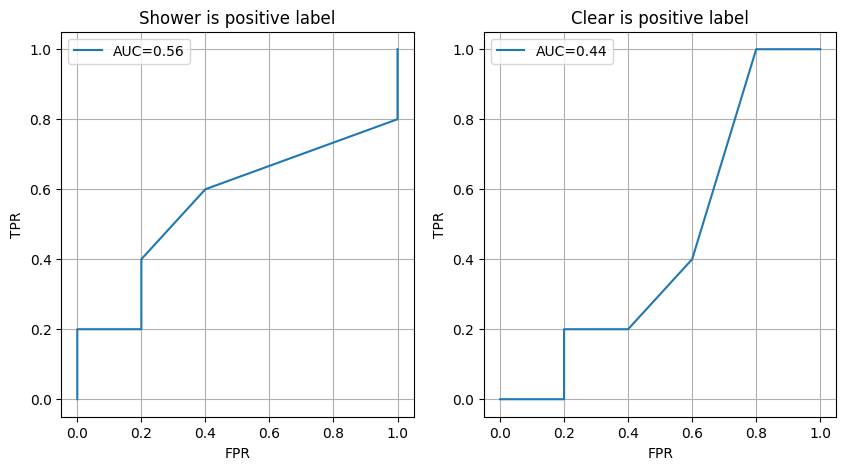

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].plot(fpr_S, tpr_S, label=f'AUC={auc_S}')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title("Shower is positive label")
axes[0].grid(visible=True)
axes[0].legend()
axes[1].plot(fpr_C, tpr_C, label=f'AUC={auc_C}')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title("Clear is positive label")
axes[1].grid(visible=True)
axes[1].legend()
plt.show()

We also use paird T-test to compare the performance of two models.

Assume we use squared error to evaluate models.

| Ground  truth | Regressor 1 | Regressor 2 |
| :-----------: | :---------: | :---------: |
|     0.55      |    0.46     |    0.66     |
|     0.51      |    0.39     |    0.41     |
|      0.8      |    0.87     |    0.92     |
|     0.74      |    0.86     |    0.65     |
|     0.02      |     0.1     |    -0.12    |
|     0.58      |    0.68     |    0.45     |
|     0.47      |    0.55     |    0.59     |
|     0.45      |    0.53     |    0.34     |
|     0.99      |    1.09     |    0.86     |
|     0.13      |    0.22     |    0.22     |


In [ ]:
y = np.array([0.55, 0.51, 0.8, 0.74, 0.02, 0.58, 0.47, 0.45, 0.99, 0.13])
y_hat_1 = np.array([0.46, 0.39, 0.87, 0.86, 0.1, 0.68, 0.55, 0.53, 1.09, 0.22])
y_hat_2 = np.array([0.66, 0.41, 0.92, 0.65, -0.12, 0.45, 0.59, 0.34, 0.86, 0.22])
n = y.shape[0]

In [ ]:
resid_1 = np.square(y_hat_1 - y)
resid_2 = np.square(y_hat_2 - y)
d = resid_1 - resid_2
print("d:", d)
t_ = np.mean(d) / np.sqrt(np.var(d, ddof=1) / n)
print("t:", t_)
t_q = t.sf(t_, df=n-1)
print("Both-side p:", (1 - t_q) * 2)

d: [-0.004   0.0044 -0.0095  0.0063 -0.0132 -0.0069 -0.008  -0.0057 -0.0069
  0.    ]
t: -2.231421359477384
Both-side p: 0.05257463778001781


Therefore, model 1 is significantly better than model 2.